In [16]:
import numpy as np
import pickle
from psiam_utils import rho_A_t_fn, rho_E_t_fn, cum_A_t_fn, rho_E_minus_t_fn, P_large_t_btn_1_2
from scipy.integrate import quad
from joblib import Parallel, delayed
from pybads import BADS
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt

# Read data

In [2]:
with open('psiam_data_5k_2.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()


RTs = RTs.flatten()

correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]


correct_RT = RTs[correct_idx]
wrong_RT = RTs[wrong_idx]

abort_idx = np.where(RTs < t_stim)[0]
abort_RT = RTs[abort_idx]

print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"t start is {t_stim}")

V_A: 1
theta_A: 2
V_E: 0.5
theta_E: 1
Num of AI process: 3765/10000
t start is 0.5


In [3]:
def calculate_abort_loglike(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    C_E = quad(rho_E_t_fn, 0, t, args=(V_E, theta_E, K_max, t_stim))[0]
    P_E = rho_E_t_fn(t, V_E, theta_E, K_max, t_stim, Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_abort = P_A * (1 - C_E) + P_E * (1 - C_A)
    if p_abort <= 0:
        p_abort = 1e-6
    return np.log(p_abort / abort_norm_term)

def calculate_correct_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_1_2 = P_large_t_btn_1_2(1, 2, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_plus = rho_E_minus_t_fn(t, -V_E, theta_E, K_max, t_stim, -Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_correct = P_A * P_E_btn_1_2 + P_E_plus * (1 - C_A)
    if p_correct <= 0:
        p_correct = 1e-6
    return np.log(p_correct / correct_norm_term)

def calculate_wrong_loglike(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term):
    P_A = rho_A_t_fn(t, V_A, theta_A, t_a)
    P_E_btn_0_1 = P_large_t_btn_1_2(0, 1, t, V_E, theta_E, Z, K_max, t_stim)
    P_E_minus = rho_E_minus_t_fn(t, V_E, theta_E, K_max, t_stim, Z, t_E)
    C_A = cum_A_t_fn(t, V_A, theta_A, t_a)
    p_wrong = P_A * P_E_btn_0_1 + P_E_minus * (1 - C_A)
    if p_wrong <= 0:
        p_wrong = 1e-6
    return np.log(p_wrong / wrong_norm_term)



def psiam_neg_loglike_fn(params):
    V_A, theta_A, V_E, theta_E, Z = params
    # hyperparams
    t_a = 0; t_E = 0; 
    K_max = 10
    
    # norm terms
    N = len(RTs)
    N_abort = len(abort_RT)
    N_correct = len(correct_RT)
    N_wrong = len(wrong_RT)

    abort_norm_term = N_abort/N
    correct_norm_term = N_correct/N
    wrong_norm_term = N_wrong/N
    n_jobs = -1  

    abort_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_abort_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, K_max, t_stim, Z, t_E, abort_norm_term)
        for t in abort_RT
    ))

    correct_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_correct_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, correct_norm_term)
        for t in correct_RT
    ))

    wrong_loglike = sum(Parallel(n_jobs=n_jobs)(
        delayed(calculate_wrong_loglike)(t, V_A, theta_A, t_a, V_E, theta_E, Z, K_max, t_stim, t_E, wrong_norm_term)
        for t in wrong_RT
    ))

    total_loglike = abort_loglike + correct_loglike + wrong_loglike

    if np.isnan(total_loglike):
        raise ValueError("Log-likelihood is NaN or infinite.")
    if np.isinf(total_loglike):
        raise ValueError("Log-likelihood is infinite.")

    return -total_loglike

    

# Test  loglike

In [33]:
print(f'loglike = {-psiam_neg_loglike_fn([V_A, theta_A, V_E, theta_E, Z_E])}')
print(f'loglike = {-psiam_neg_loglike_fn([2, theta_A, V_E, theta_E, Z_E])}')
print(f'loglike = {-psiam_neg_loglike_fn([2, theta_A, V_E, theta_E, 0.5])}')
print(f'loglike = {-psiam_neg_loglike_fn([V_A, theta_A, V_E, theta_E+0.1, Z_E])}')

loglike = -8337.297015813281
loglike = -10944.372889021812
loglike = -14475.954958702774
loglike = -9197.95382401397


In [4]:
def run_bads(lb, ub, plb, pub, x0):
    options = {'display': 'off'}
    bads = BADS(psiam_neg_loglike_fn, x0, lb, ub, plb, pub, options=options)
    optimize_result = bads.optimize()

    return optimize_result['x']

# Issue: somehow parallel is > 2x slower than serial

In [7]:
# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,1.5]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])

def generate_initial_conditions(plb, pub):
    return np.array([
        np.random.uniform(plb[0], pub[0]),  # V_A_0
        np.random.uniform(plb[1], pub[1]),  # theta_A_0
        np.random.uniform(plb[2], pub[2]),  # V_E_0
        np.random.uniform(plb[3], pub[3]),  # theta_E_0
        np.random.uniform(plb[4], pub[4])   # Z_0
    ])

def run_experiment(plb, pub, lb, ub):
    x0 = generate_initial_conditions(plb, pub)
    res = run_bads(lb, ub, plb, pub, x0)
    return res


num_workers = 20

parallel_bads_res_arr = []
with ThreadPoolExecutor(o=num_workers) as executor:
    futures = [executor.submit(run_experiment, plb, pub, lb, ub) for _ in range(num_workers)]
    
    for future in tqdm(as_completed(futures), total=num_workers):
        parallel_bads_res_arr.append(future.result())


  0%|          | 0/20 [3:02:03<?, ?it/s]


#  Serial BADS

In [35]:
all_bads_serial_result = []
N_iters = 10

# TRUE: V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,1.5]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])


for _ in tqdm(range(N_iters)):
    x0 = np.array([
        np.random.uniform(plb[0], pub[0]),  # V_A_0
        np.random.uniform(plb[1], pub[1]),  # theta_A_0
        np.random.uniform(plb[2], pub[2]),  # V_E_0
        np.random.uniform(plb[3], pub[3]),  # theta_E_0
        np.random.uniform(plb[4], pub[4])   # Z_0
    ])

    res = run_bads(lb, ub, plb, pub, x0)
    all_bads_serial_result.append(res)

100%|██████████| 10/10 [41:26<00:00, 248.61s/it]


In [9]:
all_bads_serial_results_np = np.array(all_bads_serial_result)

In [34]:
import pickle as pkl
with open('bads_psiam_20_iters_data_2.pkl', 'wb') as f:
    pkl.dump(all_bads_serial_results_np, f)

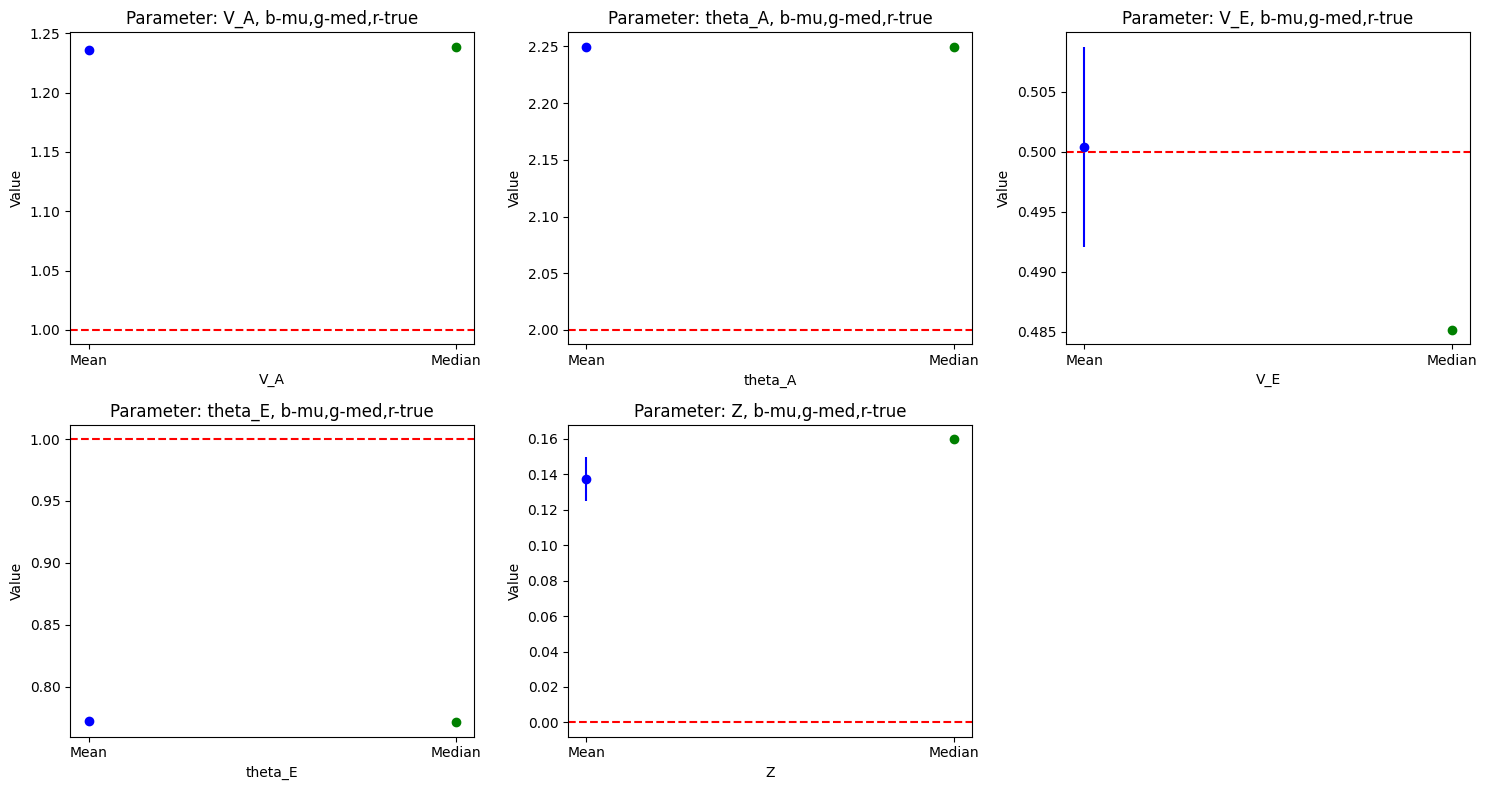

In [44]:
param_names = ["V_A", "theta_A", "V_E", "theta_E", "Z"]
true_values = [1, 2, 0.5, 1, 0]

# Create a figure with 6 subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2x3 layout for subplots

# Flatten axs for easier indexing
axs = axs.flatten()

# Iterate over each parameter to plot
for i in range(5):
    param_data = all_bads_serial_results_np[:, i]
    
    # Compute mean, SE, median, and MAD
    mean_val = np.mean(param_data)
    se_val = np.std(param_data) / np.sqrt(len(param_data))  # Standard error
    median_val = np.median(param_data)
    mad_val = median_abs_deviation(param_data)  # MAD
    
    # Plot mean with SE
    axs[i].errorbar(1, mean_val, yerr=se_val, fmt='o', color='blue', label='Mean ± SE')
    
    # Plot median with MAD
    axs[i].errorbar(2, median_val, yerr=mad_val, fmt='o', color='green', label='Median ± MAD')
    
    # Mark the true value
    axs[i].axhline(true_values[i], color='red', linestyle='--', label='True Value')
    
    # Add titles and labels
    axs[i].set_title(f'Parameter: {param_names[i]}, b-mu,g-med,r-true')
    axs[i].set_xticks([1, 2])
    axs[i].set_xticklabels(['Mean', 'Median'])
    axs[i].set_xlabel(param_names[i])
    axs[i].set_ylabel('Value')
    
    # Show legend
    # axs[i].legend()

# Hide the empty subplot
axs[5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


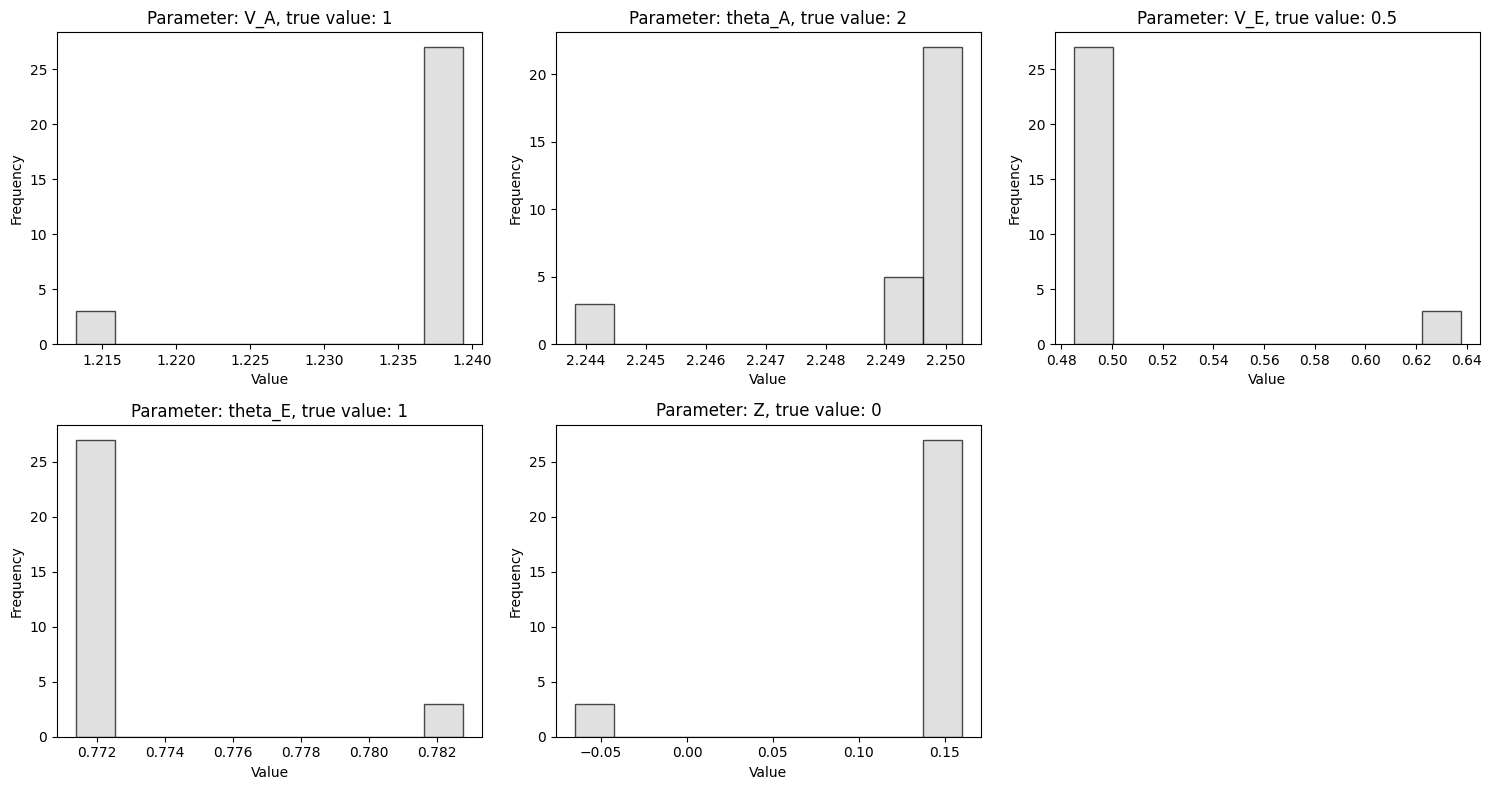

In [45]:

param_names = ["V_A", "theta_A", "V_E", "theta_E", "Z"]
true_values = [1, 2, 0.5, 1, 0]

# Create a figure with 6 subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2x3 layout for subplots

# Flatten axs for easier indexing
axs = axs.flatten()

# Iterate over each parameter to plot
for i in range(5):
    param_data = all_bads_serial_results_np[:, i]
    
    # Compute mean, median
    mean_val = np.mean(param_data)
    median_val = np.median(param_data)
    
    # Plot the histogram
    axs[i].hist(param_data, bins=10, color='lightgray', edgecolor='black', alpha=0.7, label='Distribution')
    
    # Plot mean, median, and true value lines
    # axs[i].axvline(mean_val, color='blue', linestyle='-', linewidth=2, label='Mean')
    # axs[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label='Median')
    # axs[i].axvline(true_values[i], color='red', linestyle='--', linewidth=2, label='True Value')
    
    # Add titles and labels
    axs[i].set_title(f'Parameter: {param_names[i]}, true value: {true_values[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    
    # Show legend
    # axs[i].legend()

# Hide the empty subplot
axs[5].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


# Single bads

In [5]:
# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
V_A_bounds = [0.1, 3]; V_A_plausible_bounds = [0.5, 1.5]
theta_A_bounds = [1, 3]; theta_A_plausible_bounds = [1.5, 2.5]
V_E_bounds = [-5, 5]; V_E_plausible_bounds = [-2, 2]
theta_E_bounds = [0.1, 5]; theta_E_plausible_bounds = [0.5,1.5]
Z_bounds = [-0.5, 0.5]; Z_plausible_bounds = [-0.2, 0.2]

lb = np.array([V_A_bounds[0], theta_A_bounds[0], V_E_bounds[0], theta_E_bounds[0], Z_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], V_E_bounds[1], theta_E_bounds[1], Z_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], V_E_plausible_bounds[0], theta_E_plausible_bounds[0], Z_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], V_E_plausible_bounds[1], theta_E_plausible_bounds[1], Z_plausible_bounds[1]])


V_A_0 = np.random.uniform(plb[0], pub[0])
theta_A_0 =  np.random.uniform(plb[1], pub[1])
V_E_0 = np.random.uniform(plb[2], pub[2])
theta_E_0 = np.random.uniform(plb[3], pub[3])
Z_0 = np.random.uniform(plb[4], pub[4])

x0 = np.array([V_A_0, theta_A_0, V_E_0, theta_E_0, Z_0]);

options = {'display': 'off'}
bads = BADS(psiam_neg_loglike_fn, x0, lb, ub, plb, pub, options=options)
optimize_result = bads.optimize()
x_min = optimize_result['x']


# V_A: 1 # theta_A: 2 # V_E: 0.5 # theta_E: 1 # Z = 0
print(f'Est. V_A = {x_min[0]}, True V_A = {V_A}')
print(f'Est. theta_A = {x_min[1]}, True theta_A = {theta_A}')
print(f'Est. V_E = {x_min[2]}, True V_E = {V_E}')
print(f'Est. theta_E = {x_min[3]}, True theta_E = {theta_E}')
print(f'Est. Z = {x_min[4]}, True Z = {Z_E}')

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2           14391               1                                 Uncertainty test
     0          10         8294.08               1         Initial mesh            Initial points
     0          19         7983.81               1       Successful poll           Train
     1          23         7771.35               1     Successful search (ES-wcm)        
     1          39         7771.35             0.5         Refine grid             Train
     2          40         7712.63             0.5     Successful search (ES-wcm)        
     2          43         7617.86             0.5     Successful search (ES-wcm)        
     2          49         7602.95             0.5     Successful search (ES-wcm)        
     2          53         7598.72             0.5     Successful search (ES-wcm)        
     2          55   